<a href="https://colab.research.google.com/github/abjasree/simple_neural_network_project/blob/main/fraud_detection_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gender_guesser

     |████████████████████████████████| 379 kB 5.3 MB/s 


In [ ]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import gender_guesser.detector as gender
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
%matplotlib inline 

In [ ]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv('/content/drive/MyDrive/dataset/users.csv')
    fake_users = pd.read_csv('/content/drive/MyDrive/dataset/fusers.csv')
    # print genuine_users.columns
    # print genuine_users.describe()
    #print fake_users.describe()
    x=pd.concat([genuine_users,fake_users])   
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y

In [ ]:
def predict_sex(name):
    sex_predictor = gender.Detector(case_sensitive=False)
    first_name= name.str.split(' ').str.get(0)
    sex= first_name.apply(sex_predictor.get_gender)
    sex_dict={'female': -2, 'mostly_female': -1,'unknown':0, 'andy' :0,'mostly_male':1, 'male': 2}
    sex_code = sex.map(sex_dict)
    return sex_code

In [ ]:
def extract_features(x):
        lang_list = list(enumerate(np.unique(x['lang'])))   
        lang_dict = { name : i for i, name in lang_list }             
        x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)
        x.loc[:,'sex_code']=predict_sex(x['name'])
        feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
        x=x.loc[:,feature_columns_to_use]
        return x

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    print ("False Positive rate: ",false_positive_rate)
    print ("True Positive rate: ",true_positive_rate)


    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
print("reading datasets.....\n")
x,y = read_datasets()
x.describe()

reading datasets.....



,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,profile_background_tile,utc_offset,protected,verified
count,4.879000e+03,4879.000000,4879.000000,4879.000000,4879.000000,4879.000000,3050.0,8.0,1246.0,4778.0,815.0,1808.000000,0.0,0.0
mean,5.190748e+08,1623.838287,367.892806,400.677393,207.048576,2.733142,1.0,1.0,1.0,1.0,1.0,1346.017699,NaN,NaN
std,2.933210e+08,4725.278297,8463.267199,465.025501,1284.055210,22.774626,0.0,0.0,0.0,0.0,0.0,7944.578760,NaN,NaN
min,3.610511e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-39600.000000,NaN,NaN
25%,3.255513e+08,35.000000,17.000000,181.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
50%,6.162234e+08,69.000000,25.000000,310.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
75%,6.175998e+08,1066.000000,106.000000,526.000000,30.000000,1.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
max,1.391998e+09,79876.000000,408372.000000,12773.000000,44349.000000,744.000000,1.0,1.0,1.0,1.0,1.0,36000.000000,NaN,NaN


In [ ]:
print ("extracting features.....\n")
x=extract_features(x)
print (x.columns)
print (x.describe())
print(x.head())

extracting features.....

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  ...     sex_code    lang_code
count     4879.000000      4879.000000  ...  4879.000000  4879.000000
mean      1623.838287       367.892806  ...    -0.191023     2.755073
std       4725.278297      8463.267199  ...     1.693751     1.983135
min          0.000000         0.000000  ...    -2.000000     0.000000
25%         35.000000        17.000000  ...    -2.000000     1.000000
50%         69.000000        25.000000  ...     0.000000     1.000000
75%       1066.000000       106.000000  ...     2.000000     5.000000
max      79876.000000    408372.000000  ...     2.000000     7.000000

[8 rows x 7 columns]
   statuses_count  followers_count  ...  sex_code  lang_code
0           20370             5470  ...         2          5
1            3131              506  ...        -

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler


def train(x_train,y_train,x_test):
    """ Trains and predicts dataset with a Neural Network classifier """
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    y_train = np.array(y_train)
    model = Sequential()
    model.add(Dense(5, input_dim=len(x_train[1]), activation='relu'))
   
    model.add(Dense(1, activation='sigmoid'))
	  # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
   # y_train = y_train.map(one_hot_matrix)
	  # fit the keras model on the dataset
    history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=10)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    predictions = (model.predict(x_test) > 0.5).astype(int)
    return predictions
    
   	  

In [ ]:
print ("spliting datasets in train and test dataset...\n")
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.30, random_state=44)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape[0])
print(X_test.shape[0])

spliting datasets in train and test dataset...

3415
1464


training datasets.......

Epoch 1/100
229/229 [==============================] - 1s 3ms/step - loss: 0.6985 - accuracy: 0.5503 - val_loss: 0.6141 - val_accuracy: 0.7480
Epoch 2/100
229/229 [==============================] - 0s 2ms/step - loss: 0.4994 - accuracy: 0.8204 - val_loss: 0.4407 - val_accuracy: 0.8270
Epoch 3/100
229/229 [==============================] - 0s 2ms/step - loss: 0.3551 - accuracy: 0.9191 - val_loss: 0.3246 - val_accuracy: 0.9379
Epoch 4/100
229/229 [==============================] - 0s 2ms/step - loss: 0.2553 - accuracy: 0.9471 - val_loss: 0.2492 - val_accuracy: 0.9379
Epoch 5/100
229/229 [==============================] - 0s 2ms/step - loss: 0.2012 - accuracy: 0.9480 - val_loss: 0.2151 - val_accuracy: 0.9388
Epoch 6/100
229/229 [==============================] - 0s 2ms/step - loss: 0.1778 - accuracy: 0.9484 - val_loss: 0.2009 - val_accuracy: 0.9388
Epoch 7/100
229/229 [==============================] - 0s 2ms/step - loss: 0.1672 - accuracy: 0.9497 - val_loss: 0.1

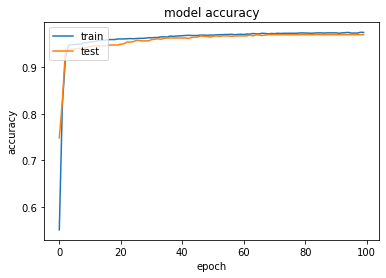

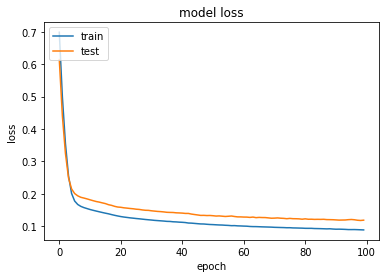

In [ ]:
print ("training datasets.......\n")
y_pred = train(X_train,y_train,X_test)

Confusion matrix, without normalization
[[707  30]
 [  6 721]]


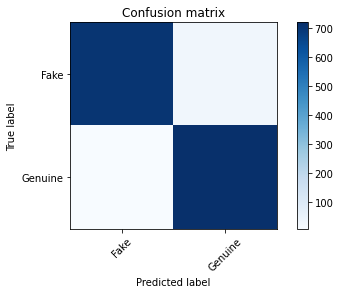

In [ ]:
y_test = np.array(y_test)
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)

In [ ]:
print(y_test)

[1 0 0 ... 1 0 0]


In [ ]:
print(y_pred)

[[1]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]


In [ ]:
print('Classification Accuracy on Test dataset: ' ,accuracy_score(y_test, y_pred))

Classification Accuracy on Test dataset:  0.9754098360655737


In [ ]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))


              precision    recall  f1-score   support

        Fake       0.99      0.96      0.98       737
     Genuine       0.96      0.99      0.98       727

    accuracy                           0.98      1464
   macro avg       0.98      0.98      0.98      1464
weighted avg       0.98      0.98      0.98      1464



False Positive rate:  [0.         0.04206242 1.        ]
True Positive rate:  [0.         0.99174691 1.        ]


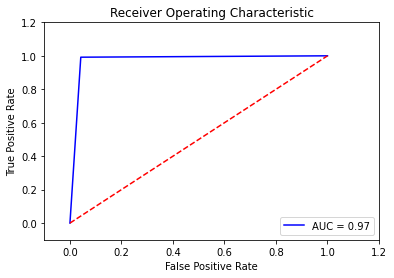

In [ ]:
plot_roc_curve(y_test, y_pred)

In [ ]:
print(accuracy_score(y_test, y_pred))

0.9747267759562842
